<div>
  <img style="float: left;"  width="140" src=" 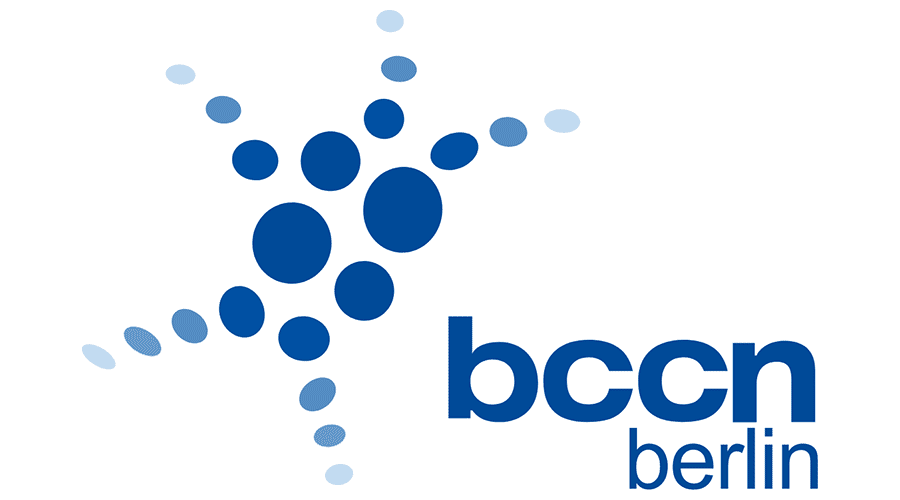">
</div>

<h1 id="course-title-heading">
    <div style="text-align: right">
        Computational Modeling Practical Course
        <br>
    </div>
</h1>

<div style="text-align: left; float: left">
    Bernstein Center for Computational Neuroscience Berlin
    <br>Lecturer: Prof. Dr. Henning Sprekeler
    <br>Tutors: Simone Ciceri
</div>

<br>
<h2>
<br>
<br>Final Project
</h2>

<div style="text-align: left">
    Gerardo Parra
</div>

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.stats import norm
import matplotlib.pyplot as plt

## Introduction
Reports of mental disorders that interfere with focus and task execution, such as major deppressive disorder and attention deficit hyperactivity disorder, have been increasing for several years **(cite)**. Moreover, sociological trends such as growing proportions of young people who identify as introverted and spread of concepts like "bed rotting" point towards a population increasingly struggling with motivation and energy. While the underlying causes are undoubtedly numerous and difficult to disentangle, a mathematical model of the phenomenologically experience of motivation and energy could provide a framework for assessing important factors. I created a **n-dimensional** system to study the dynamics of motivation and energy in response to personal decisions and environmental influences, such as food, sleep and circadian rhythms, mental and physical activity

The physiological and psychological processes underlying these two variables are complex and high dimensional: it is not possible to capture all relevant parts in a simple, interpretable model and particualrly within the scope of this project. Moreover, the goal of this project is primarily the application of the mathematical repertoire we developed in class, not scientific accuracy. I therefore emphasize that while I conducted some superficial reserach to inform the development of this model, the model is partly formed by intuition and is not rigorously scientifically based.

## Methods
First I define some basic terminology and distinguish certain similar concepts.

I then state my assumptions and conventions.

I begin by modeling the human circadian rhythm. The circadian rhythm is an automatic internal clock regulating alertness which is highly sensitive to light input. The circadian rhythm has an intrinsic period slightly greater than 24 hours long (24.18 hours), but resets its phase in response to light input. Given the relation of this internal clock to the sensation of alertness and drowsiness, we begin by modeling this system.
\begin{align}
\frac{d^2C}{dt^2} = -(\omega + L)^2C
\end{align}

This is equivalent to
\begin{align}
C(t) = A\text{cos}\left(\left[\omega+L\right]t+\phi\right)
\end{align}

## 1. Circadian rhythm

### a. Phase response curve

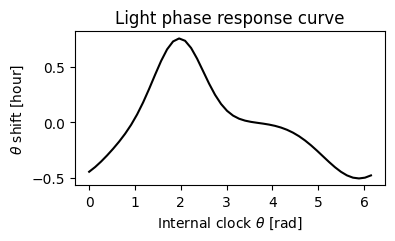

In [56]:
day = np.arange(0, 24, 0.5)
                
# Convert to phase in radians
phi = lambda x, w: x / w * 2 * np.pi

# Define PRC by summing Gaussian PDFs
def PRC(phase):
    return norm.pdf(phase,loc=5*np.pi/8,scale=np.pi/6)-norm.pdf(phase,loc=15*np.pi/8,scale=np.pi/4)-norm.pdf(phase,loc=-np.pi/8,scale=np.pi/4)

# Plot phase response curve
plt.figure(figsize=(4,2))
plt.plot(phi(day,24), PRC(phi(day,24)), 'k')
plt.xlabel(r'Internal clock $\theta$ [rad]'), plt.ylabel(r'$\theta$ shift [hour]')
plt.title('Light phase response curve')
plt.show()

### b. Circadian rhythm with phase leakily integrating light input

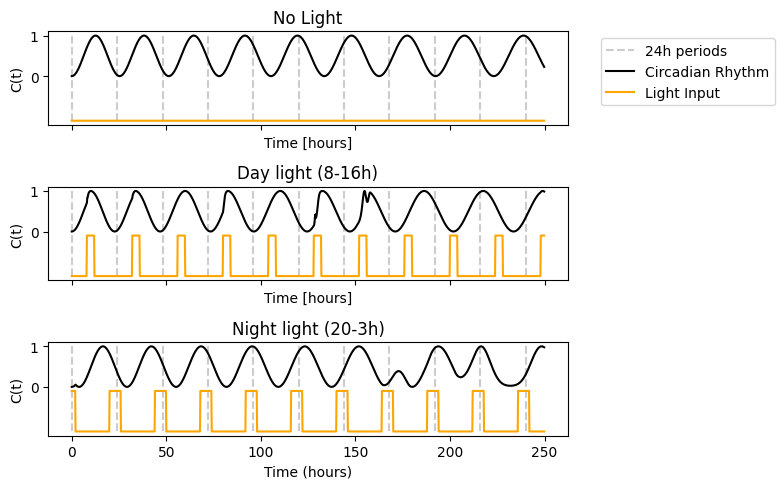

In [57]:
# Simulation parameters 
t_span = (0, 250)
t_eval = np.arange(t_span[0], t_span[1], 0.2)
days   = np.arange(t_span[0], t_span[1]+1, 24)
# Initial conditions
y0 = [0]  

# Define Light nonlinearity as a function of internal clock phase
def f_L(theta, L, alpha_L=1):
    return alpha_L * PRC(theta) * L


# Create light input with configurable hours and intensity
def L_input(t, params):
    """
    Determines light input based on time of day.
    
    Parameters:
    - t: scalar or numpy array of time values (hours).
    - light_on_hours: List of tuples [(start, end)] defining light-on periods.
    
    Returns:
    - A numpy array (or scalar) indicating light presence (1 for on, 0 for off).
    """
    t_mod = np.mod(t, 24)  # Convert to 24-hour cycle
    light = np.zeros_like(t_mod, dtype=int)
    
    for start, end in params['hours']:
        light |= (t_mod >= start) & (t_mod < end)
    
    return params['amp'] * light

def energy_dynamics(t, y, light_params, period=25):
    # Unpack variables
    theta = y[0]
    # Circadian phase dynamics
    freq = 2 * np.pi/period
    # print(t, theta %(2*np.pi), f_L(theta % (2*np.pi), L_input(t,light_params)))
    # if L_input(t,light_params) > 0:
    #     print(t,theta,f_L(theta % (2*np.pi), L_input(t,light_params)))
    dtheta_dt = freq + f_L(theta % (2*np.pi), L_input(t,light_params)) - .001 * theta
    return [dtheta_dt]

def plot_circadian_solution(solution, ax=None, figsize=(6,3)):
    rhythm = (1 + -np.cos(solution.y[0])) / 2  # Normalize oscillation to [0,1]
    # rhythm = solution.y[0]

    new_fig = ax is None  # Check if we need to create a new figure
    if new_fig:
        fig, ax = plt.subplots(figsize=figsize)  # Create new figure if no axis is given
    else:
        fig = ax.get_figure()  # Get the parent figure of the existing axis

    ax.plot(solution.t, rhythm, 'k')
    ax.set_xlabel("Time [hours]")
    ax.set_ylabel("C(t)")
    ax.set_title("Circadian Rhythm Solution")

    if new_fig:
        plt.show()  # Show only if a new figure was created

    return fig, ax  # Return figure and axis for customization

# Simulate system with 3 different types of light inputs
light_none  = {'hours': [], 'amp': 1}
light_day   = {'hours': [(8,12)], 'amp': 1}
light_night = {'hours': [(20,24),(0,2)], 'amp': 1}
sol_base       = solve_ivp(energy_dynamics, t_span, y0, t_eval=t_eval, args=(light_none,))
sol_daylight   = solve_ivp(energy_dynamics, t_span, y0, t_eval=t_eval, args=(light_day,), method='DOP853')
sol_nightlight = solve_ivp(energy_dynamics, t_span, y0, t_eval=t_eval, args=(light_night,)) #, method='DOP853')


fig, ax = plt.subplots(3, 1, figsize=(8, 5), sharex=True)  # Three subplots with shared x-axis

light_schedules = [light_none, light_day, light_night]
solutions = [sol_base, sol_daylight, sol_nightlight]
titles = ["No Light", "Day light (8-16h)", "Night light (20-3h)"]

for i in range(3):
    # Add vertical lines for 24-hour periods
    ax[i].vlines(days, -1.1, 1, colors='#ccc', linestyles='dashed', label="24h periods")

    # Plot circadian rhythm
    plot_circadian_solution(solutions[i], ax=ax[i])
    
    # Plot light input, shifted for visibility
    ax[i].plot(solutions[i].t, L_input(solutions[i].t, light_schedules[i]) - 1.1, label="Light Input", color="orange")

    # Set labels and titles
    ax[i].set_title(titles[i])
    ax[i].set_yticks([0, 1])

# Add legend outside
ax[0].legend(["24h periods", "Circadian Rhythm", "Light Input"], loc="upper left", bbox_to_anchor=(1.05, 1))

plt.xlabel("Time (hours)")
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [129]:
light_shift = f_L(day, L_input(day,light_hrs=[(8, 15)]), alpha_L=0.1)
np.sum(light_shift)

np.float64(1.008589653179565)

In [130]:
light_shift = f_L(day, L_input(day,light_hrs=[(20,24),(0,3)]), alpha_L=0.1)
np.sum(light_shift)

np.float64(-1.008589653179565)

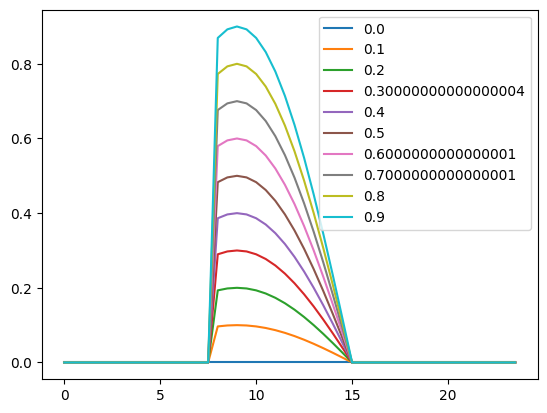

In [124]:
for i in np.arange(0,1,0.1):
    light_shift = f_L(day, L_input(day,light_hrs=[(8, 15)]), alpha_L=i)
    plt.plot(day, light_shift, label=f'{i}')
plt.legend()